<a href="https://colab.research.google.com/github/maxlshk/python-big-data/blob/main/Practise_1_CVDL_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №1
## Класифікація зображень за допомогою PyTorch

**Мета роботи: Навчитись тренувати базову нейронну мережу для класифікації зображень.**

**Вимоги:**

1.   Встановлені Python та бібліотеки PyTorch, torchvision, matplotlib.
2.   Завантажений набір даних CIFAR-10.

## Завдання до лабораторної роботи (частина І): Робота з даними (CIFAR-10)

1.   Імпортуйте необхідні бібліотеки:
```
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
```
2.   Завантаження даних. Напишіть функцію, яка завантажує набір даних CIFAR-10.
3.   Перевірка наявності даних. Напишіть код, який перевіряє, чи дані завантажені та розпаковані успішно. Виведіть повідомлення про статус завантаження.
4.   Підготовка даних. Напишіть код, щоб імплементувати трансформації для зображень:
*    перетворення в тензори;
*    денормалізація (при необхідності).  

Використайте `torchvision.transforms` для підготовки даних.
5.   Створення DataLoader. Створіть DataLoader для навчального та тестового наборів даних, щоб спростити процес завантаження даних за батчами.
6.   Візуалізація прикладів:
*   напишіть функцію для візуалізації деяких зображень з набору даних;
*   відобразіть кілька зображень з їхніми реальними мітками.
7.   Ваші висновки до частини І.

## Завдання до лабораторної роботи (частина ІІ):
0. Розділіть набір даних на навчальний і тестовий.
1. Визначення структури CNN.
    - Створіть клас для цільної нейронної мережі, яка буде містити мінімум два повнозв'язних шари.
2. Вибір функції втрати та оптимізатора:
    - визначте функцію втрат (наприклад, CrossEntropyLoss) та оптимізатор (наприклад, SGD або Adam).
3. Тренування моделі.
    - Реалізуйте цикл навчання, де:
        - модель тренується на навчальному наборі даних;
        - виводиться значення функції втрат та точність (на навчальній та валідаційній множинах) після кожної епохи.
4. Оцінка моделі:
    - визначте точність моделі на тестовому наборі даних;
    - виведіть детальні статистики (загальна точність та точність для кожного класу).
5. Візуалізація результатів:
    - візуалізуйте кілька випадкових передбачених зображень разом з їхніми реальними мітками та передбаченнями;
    - побудуйте графік точності та втрат для навчального набору даних на кожній епосі.

## Додаткові завдання (за бажанням):

- Напишіть код, який виведе кількість зображень у кожному класі в директорії train. Для цього ви можете використовувати os.listdir() для підрахунку зображень у відповідних піддиректоріях.
- Створіть графік (наприклад, гістограму), який відображає кількість зображень в кожному класі. Ви можете використовувати бібліотеку matplotlib для візуалізації.
- Виведіть кілька випадкових зображень з кожного класу разом із їхніми мітками.
- Дослідіть, як зміна параметрів підготовки даних (наприклад, різні трансформації) впливає на результати моделі.
- Спробуйте змінити архітектуру моделі (додати додаткові шари) та проаналізуйте, як це впливає на результати.
- Включіть регуляризацію (наприклад, Dropout) для покращення загальної точності.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

In [2]:
# Define transforms for data preparation.
# Here we convert images to tensors and normalize them using CIFAR-10's typical mean and std.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download and load the training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Print status messages to check successful download
print("Training data loaded: {} images".format(len(trainset)))
print("Test data loaded: {} images".format(len(testset)))


100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training data loaded: 50000 images
Test data loaded: 10000 images


In [3]:
# Create DataLoader objects to load data in batches.
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


<Figure size 1000x1000 with 0 Axes>

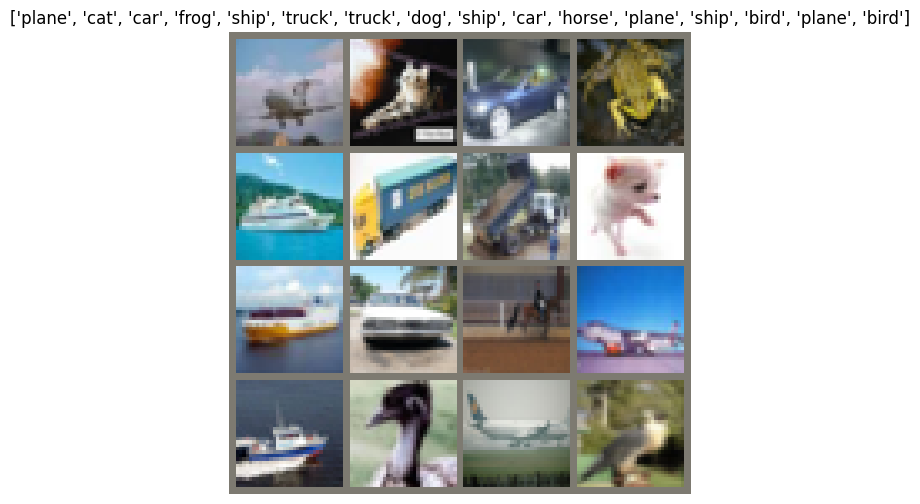

In [5]:
# Define a helper function to denormalize and display images.
def denormalize(img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    # Clone the tensor to avoid modifying the original data.
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

def imshow(img, title=None):
    # img: a Tensor image of shape (C, H, W)
    img = denormalize(img)
    npimg = img.numpy()
    plt.figure(figsize=(8, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Create a grid of images and display them along with their labels
img_grid = make_grid(images[:16], nrow=4)
plt.figure(figsize=(10,10))
imshow(img_grid, title=[classes[lab] for lab in labels[:16].tolist()])


In [6]:
# Split the original training set into a new training set and a validation set.
# For example, 80% for training and 20% for validation.
train_size = int(0.8 * len(trainset))
val_size   = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for the new training and validation sets.
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Training subset size:", len(train_subset))
print("Validation subset size:", len(val_subset))


Training subset size: 40000
Validation subset size: 10000


In [7]:
# Define a simple CNN for CIFAR-10 classification with two fully connected layers.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        # Fully connected layers: input size becomes 64 * 8 * 8 after two pooling layers (32 -> 16 -> 8)
        self.fc1   = nn.Linear(64 * 8 * 8, 256)
        self.fc2   = nn.Linear(256, 10)

        # Optional dropout for regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the available device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(model)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [8]:
# Use CrossEntropyLoss (which combines softmax and negative log likelihood) and Adam optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [9]:
# Training loop parameters
num_epochs = 10

train_losses = []
val_losses   = []
train_accuracies = []
val_accuracies   = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()           # Zero the parameter gradients
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    epoch_loss = running_loss / total_train
    epoch_acc  = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluate on validation set
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_epoch_loss = running_val_loss / total_val
    val_epoch_acc  = correct_val / total_val
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


Epoch 1/10 - Train Loss: 1.3423, Train Acc: 0.5161 - Val Loss: 1.0730, Val Acc: 0.6122
Epoch 2/10 - Train Loss: 0.9766, Train Acc: 0.6536 - Val Loss: 0.9640, Val Acc: 0.6581
Epoch 3/10 - Train Loss: 0.8256, Train Acc: 0.7107 - Val Loss: 0.8838, Val Acc: 0.6873
Epoch 4/10 - Train Loss: 0.7016, Train Acc: 0.7525 - Val Loss: 0.8299, Val Acc: 0.7113
Epoch 5/10 - Train Loss: 0.6053, Train Acc: 0.7873 - Val Loss: 0.8166, Val Acc: 0.7147
Epoch 6/10 - Train Loss: 0.5158, Train Acc: 0.8168 - Val Loss: 0.8479, Val Acc: 0.7098
Epoch 7/10 - Train Loss: 0.4362, Train Acc: 0.8456 - Val Loss: 0.8876, Val Acc: 0.7144
Epoch 8/10 - Train Loss: 0.3742, Train Acc: 0.8655 - Val Loss: 0.9087, Val Acc: 0.7169
Epoch 9/10 - Train Loss: 0.3228, Train Acc: 0.8855 - Val Loss: 0.9441, Val Acc: 0.7223
Epoch 10/10 - Train Loss: 0.2787, Train Acc: 0.9009 - Val Loss: 1.0118, Val Acc: 0.7155


In [10]:
# Evaluate model performance on the test set and compute per-class accuracy.
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

# Initialize per-class correct prediction counters
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_test += targets.size(0)
        correct_test += (predicted == targets).sum().item()

        # Per-class statistics
        c = (predicted == targets).squeeze()
        for i in range(len(targets)):
            label = targets[i]
            class_correct[label] += c[i].item() if c.dim() > 0 else c.item()
            class_total[label] += 1

overall_acc = correct_test / total_test
print("Test Loss: {:.4f}, Overall Test Accuracy: {:.4f}".format(test_loss/total_test, overall_acc))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))


Test Loss: 1.0245, Overall Test Accuracy: 0.7145
Accuracy of plane : 74 %
Accuracy of   car : 80 %
Accuracy of  bird : 62 %
Accuracy of   cat : 48 %
Accuracy of  deer : 70 %
Accuracy of   dog : 61 %
Accuracy of  frog : 71 %
Accuracy of horse : 80 %
Accuracy of  ship : 83 %
Accuracy of truck : 80 %


<Figure size 1000x1000 with 0 Axes>

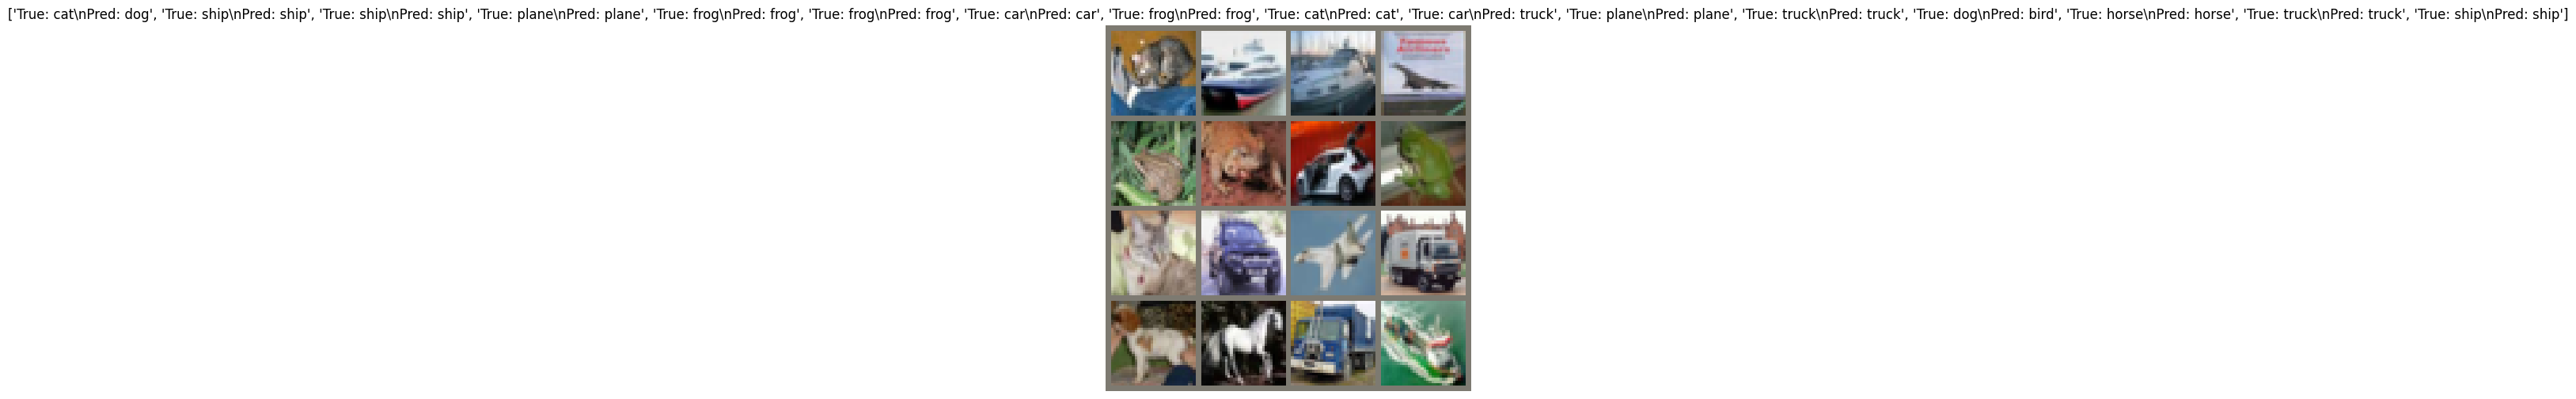

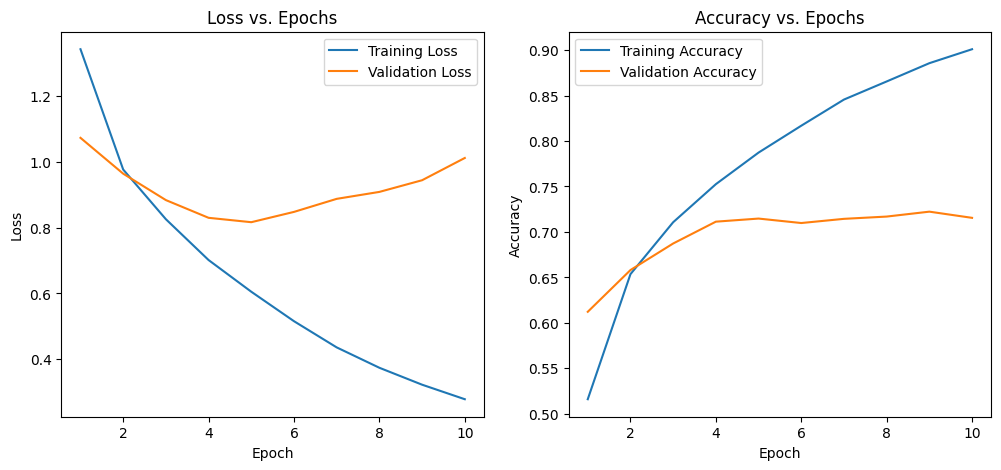

In [12]:
# Visualize a few random test images along with predicted and true labels.
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get model predictions for this batch
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Move images to CPU for display and denormalize them for proper visualization
images = images.cpu()
predicted = predicted.cpu()

# Display the first 16 images from the batch
img_grid = make_grid(images[:16], nrow=4)
plt.figure(figsize=(10,10))
# Prepare titles with true label and prediction
titles = [f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}" for i in range(16)]
imshow(img_grid, title=titles)

# Plot training and validation loss and accuracy curves
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.show()


Number of images per class in the training set:
plane: 5000
car: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


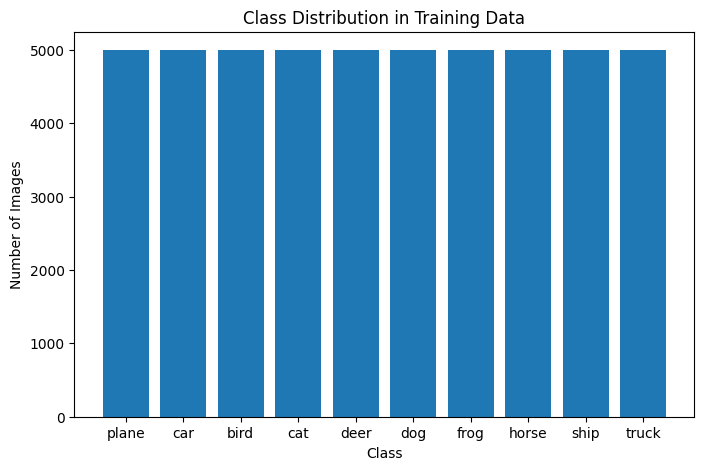

<Figure size 1000x200 with 0 Axes>

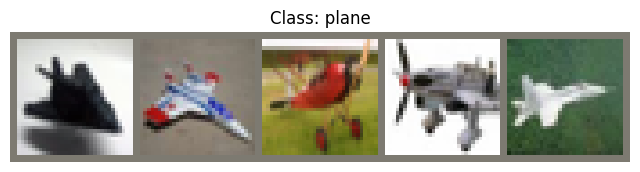

<Figure size 1000x200 with 0 Axes>

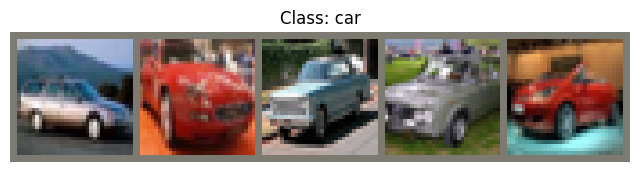

<Figure size 1000x200 with 0 Axes>

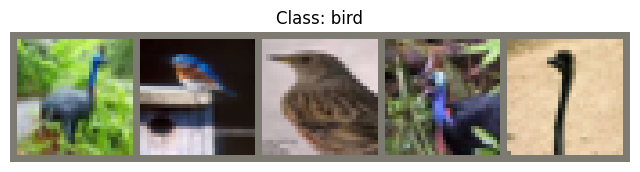

<Figure size 1000x200 with 0 Axes>

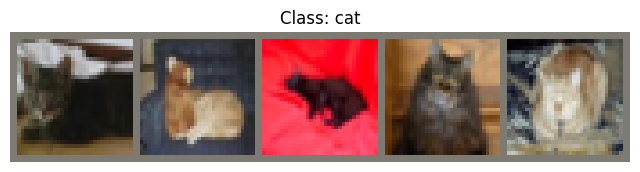

<Figure size 1000x200 with 0 Axes>

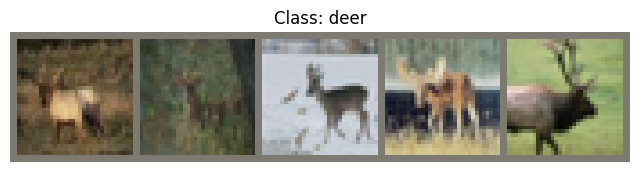

<Figure size 1000x200 with 0 Axes>

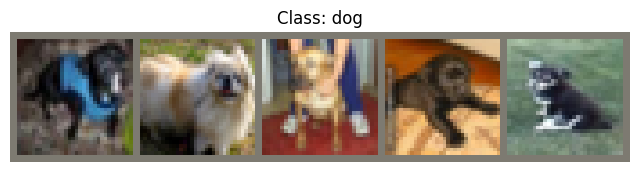

<Figure size 1000x200 with 0 Axes>

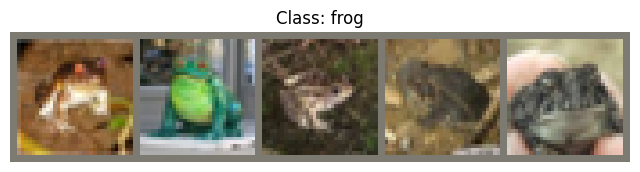

<Figure size 1000x200 with 0 Axes>

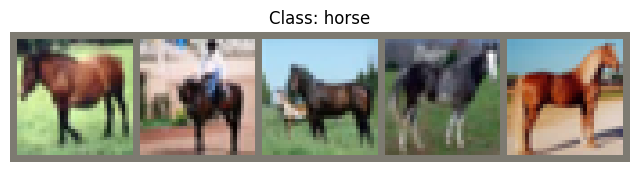

<Figure size 1000x200 with 0 Axes>

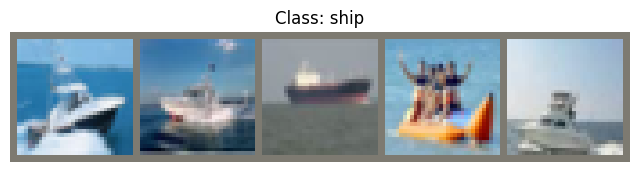

<Figure size 1000x200 with 0 Axes>

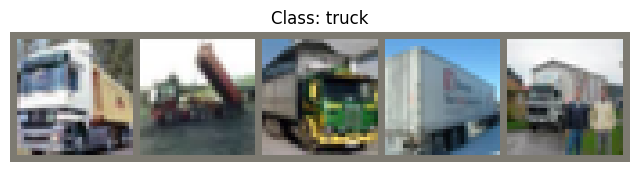

In [13]:
# Count the number of images per class in the training set using the dataset object.
class_counts = {cls: 0 for cls in classes}

# Since CIFAR-10's trainset stores targets in a list, we can iterate over it.
for label in trainset.targets:
    class_counts[classes[label]] += 1

print("Number of images per class in the training set:")
for cls in classes:
    print(f"{cls}: {class_counts[cls]}")

# Plot a histogram of the class distribution.
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Data")
plt.show()

# Display a few random images from each class along with their labels.
def show_random_images_per_class(dataset, classes, samples_per_class=5):
    # Create a dictionary to hold images for each class
    images_per_class = {cls: [] for cls in classes}

    # Iterate over the dataset to collect images for each class
    for img, label in dataset:
        if len(images_per_class[classes[label]]) < samples_per_class:
            images_per_class[classes[label]].append(img)
        # Break if we have enough samples for each class
        if all(len(imgs) >= samples_per_class for imgs in images_per_class.values()):
            break

    # Plot images for each class
    for cls in classes:
        imgs = images_per_class[cls]
        grid = make_grid(imgs, nrow=samples_per_class)
        plt.figure(figsize=(10,2))
        imshow(grid, title=f"Class: {cls}")

show_random_images_per_class(trainset, classes)
